<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/demo_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/benihime91/pytorch_retinanet.git # Clone the Repo

Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 614 (delta 115), reused 99 (delta 52), pack-reused 446
Receiving objects: 100% (614/614), 489.12 KiB | 10.41 MiB/s, done.
Resolving deltas: 100% (390/390), done.


In [2]:
# Extracting the Data assuming data is stored in `/content/drive/My Drive/Data/oxford-iiit-pet.tgz`
! tar zxf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/ 
! echo "Data Unziped"

Data Unziped


In [3]:
%%bash
# Colab Setup : Install Required Libraries
pip install -U pytorch-lightning --quiet
pip install -U git+https://github.com/albumentations-team/albumentations --quiet
pip install -U bounding_box --quiet
echo " >> Libraries successfully installed !"

 >> Libraries successfully installed !


ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.


In [4]:
import os 
os.chdir('/content/pytorch_retinanet')

# RetinaNet Imports
from src.models import Retinanet
from src.eval_utils.coco_eval import CocoEvaluator
from src.eval_utils.coco_utils import get_coco_api_from_dataset

# Standard Imports
import pytorch_lightning as pl

import torch
import torchvision
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from bounding_box import bounding_box as bb
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd
import numpy as np
from sklearn import preprocessing, model_selection
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
import re
import xml.etree.ElementTree as ET
from pathlib import Path

pl.seed_everything(219)
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None, 'display.max_rows', None)


%matplotlib inline
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [5]:
## IMAGE PATHS

img_desc = Path('/content/oxford-iiit-pet/images')
annot_dir = Path("/content/oxford-iiit-pet/annotations/xmls")
annots = list(annot_dir.iterdir())
annots = [str(a) for a in annots]


def xml_to_csv(pths):
    """Extracts the filenames and the bboxes from the xml_list"""
    xml_list = []
    for xml_file in pths:
        # Read in the xml file
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for m in root.findall("object"):
            try:
                value = (
                    # Extract the path to the image
                    str(img_desc/root.find("filename").text),
                    # Extract the bounding boxes
                    # 1. xmin
                    float(m[4][0].text),
                    # 2. ymin
                    float(m[4][1].text),
                    # 3. xmax
                    float(m[4][2].text),
                    # 4. ymax
                    float(m[4][3].text),
                )
                xml_list.append(value)
            except: pass
    col_n = ["filename", "xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(xml_list, columns=col_n)
    return df



# --------------------------------------------------------------------------------------------------
# Fix Data
# --------------------------------------------------------------------------------------------------

df = xml_to_csv(annots)

pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)

# 1. Extract the label
df["class"] = [pat.search(fname).group(1).lower() for fname in df.filename]

# 2. Convert the classes to integers add +1 becaus0 is background class for `FasterRCNN`
le = preprocessing.LabelEncoder()
df["target"] = le.fit_transform(df["class"].values) + 1

# 3. Shuffle the dataFrame
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/oxford-iiit-pet/images/shiba_inu_132.jpg,21.0,125.0,334.0,400.0,shiba_inu,32
1,/content/oxford-iiit-pet/images/Birman_175.jpg,112.0,33.0,392.0,275.0,birman,7
2,/content/oxford-iiit-pet/images/Persian_126.jpg,260.0,60.0,375.0,143.0,persian,24
3,/content/oxford-iiit-pet/images/beagle_113.jpg,15.0,118.0,275.0,395.0,beagle,5
4,/content/oxford-iiit-pet/images/saint_bernard_107.jpg,189.0,42.0,311.0,155.0,saint_bernard,29


In [6]:
# Take a small subset to train
df, _ = model_selection.train_test_split(df, stratify=df.target, test_size=0.5, shuffle=True)
df.reset_index(drop=True, inplace=True)


cls_names = df['class'].unique()
cls_idxs  = le.transform(cls_names)
cls_dict  = {key:value for key,value in list(zip(list(cls_idxs), list(cls_names)))}

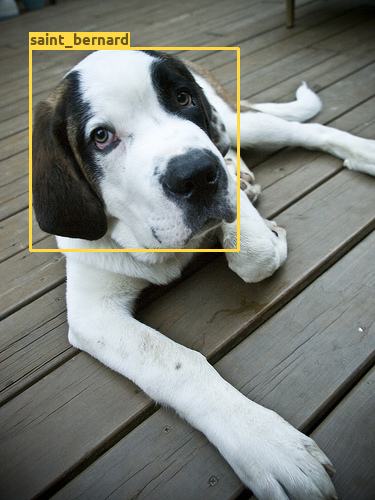

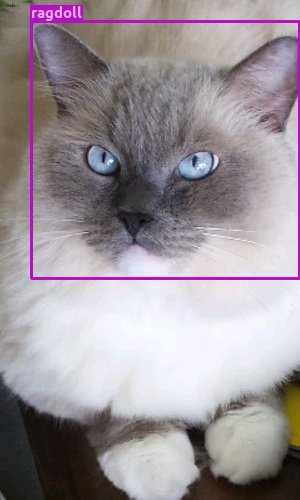

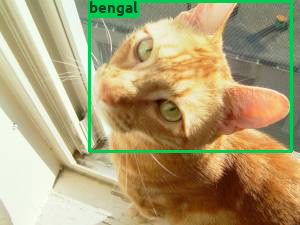

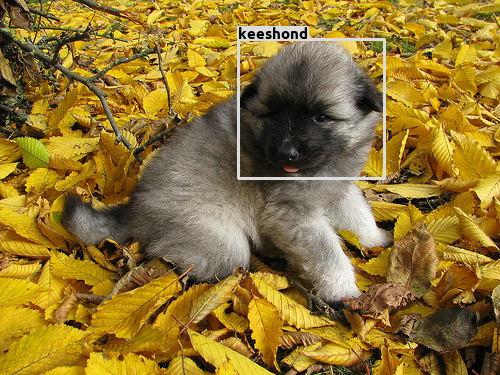

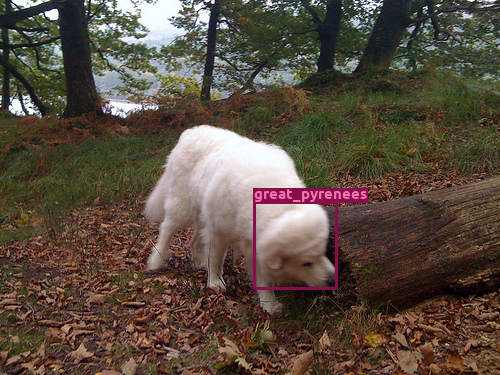

In [7]:
def display_image():
    
    "Display Images"
    
    im = cv2.imread(df.filename[0])
    bb.add(im, df.xmin[0], df.ymin[0], df.xmax[0], df.ymax[0], label=f'{df["class"][0]}')
    cv2_imshow(im)

    im = cv2.imread(df.filename[1])
    bb.add(im, df.xmin[1], df.ymin[1], df.xmax[1], df.ymax[1], label=f'{df["class"][1]}')
    cv2_imshow(im)

    im = cv2.imread(df.filename[3])
    bb.add(im, df.xmin[3], df.ymin[3], df.xmax[3], df.ymax[3], label=f'{df["class"][3]}')
    cv2_imshow(im)

    im = cv2.imread(df.filename[4])
    bb.add(im, df.xmin[4], df.ymin[4], df.xmax[4], df.ymax[4], label=f'{df["class"][4]}')
    cv2_imshow(im)

    im = cv2.imread(df.filename[10])
    bb.add(im, df.xmin[10], df.ymin[10], df.xmax[10], df.ymax[10], label=f'{df["class"][10]}')
    cv2_imshow(im)


display_image()

In [8]:
df_train, df_test = model_selection.train_test_split(
    df, stratify=df['target'], test_size=0.25, shuffle=True
    )

df_train.reset_index(drop=True, inplace=True)
df_train.head()

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/oxford-iiit-pet/images/Birman_136.jpg,303.0,40.0,398.0,126.0,birman,7
1,/content/oxford-iiit-pet/images/yorkshire_terrier_171.jpg,66.0,184.0,287.0,329.0,yorkshire_terrier,37
2,/content/oxford-iiit-pet/images/Russian_Blue_157.jpg,136.0,30.0,295.0,203.0,russian_blue,28
3,/content/oxford-iiit-pet/images/Birman_113.jpg,108.0,41.0,289.0,194.0,birman,7
4,/content/oxford-iiit-pet/images/havanese_12.jpg,65.0,104.0,299.0,300.0,havanese,17


In [9]:
df_test.reset_index(drop=True, inplace=True)
df_test.head()

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/oxford-iiit-pet/images/Sphynx_157.jpg,241.0,16.0,349.0,127.0,sphynx,34
1,/content/oxford-iiit-pet/images/wheaten_terrier_186.jpg,232.0,30.0,360.0,156.0,wheaten_terrier,36
2,/content/oxford-iiit-pet/images/Sphynx_146.jpg,168.0,27.0,324.0,197.0,sphynx,34
3,/content/oxford-iiit-pet/images/keeshond_121.jpg,239.0,47.0,386.0,203.0,keeshond,19
4,/content/oxford-iiit-pet/images/miniature_pinscher_127.jpg,115.0,29.0,226.0,145.0,miniature_pinscher,22


In [10]:
print("No. of Training Examples: ",   len(df_train))
print("No. of Validation Examples: ", len(df_test)) 

# --------------------------------------------------------------------------------------------------
# IMAGE TRANSFORMATIONS
# --------------------------------------------------------------------------------------------------

transformations = [
    A.HorizontalFlip(p=0.5),
    A.CLAHE(),
    A.IAASharpen(),
    A.IAAPerspective(),
    A.OneOf([
        A.ShiftScaleRotate(),
        A.Rotate(limit=60),
    ], p=1.0),
    A.OneOf([
        A.RandomShadow(),
        A.RandomBrightnessContrast(),
        A.Cutout()
    ], p=0.5)
]

# Train Transformations
train_transformations = transformations + [ A.ToFloat(max_value=255., always_apply=True), 
                                            ToTensorV2(always_apply=True) ]

# Valid Transformations
valid_transformations = [ A.ToFloat(max_value=255., always_apply=True), 
                          ToTensorV2(always_apply=True) ]

# Transformations:
transforms = {
    "train":A.Compose(train_transformations, p=1.0, bbox_params=A.BboxParams(format="pascal_voc", 
                                                                             label_fields=["class_labels"])),
              
    "valid": A.Compose(valid_transformations, p=1.0, bbox_params=A.BboxParams(format="pascal_voc", 
                                                                              label_fields=["class_labels"]))
    }


class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, train=False):
        self.df = dataframe
        self.image_ids = self.df["filename"]

        if train:
            self.tfms  = transforms['train']
        else:
            self.tfms  = transforms['valid']

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Grab the Image
        image_id = self.image_ids[idx]
        im       = cv2.cvtColor(cv2.imread(image_id), cv2.COLOR_BGR2RGB)

        # extract the bounding boxes
        records = self.df[self.df['filename'] == image_id]
        boxes   = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        # claculate area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Grab the Class Labels
        class_labels = records['target'].values.tolist()

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        # apply transformations
        transformed = self.tfms(image=im, bboxes=boxes, class_labels=class_labels)
        image = transformed["image"]
        boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
        class_labels = torch.tensor(transformed["class_labels"])

        # target dictionary
        target = {}
        image_idx = torch.tensor([idx])
        target['image_id'] = image_idx
        target['boxes']    = boxes
        target['labels']   = class_labels
        target['area']     = area
        target['iscrowd']  = iscrowd

        return image, target, image_idx

No. of Training Examples:  1382
No. of Validation Examples:  461


In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))


def disp_batch(batch) -> None:
    " funtion to display batch"
    image, target, _ = batch
    n = np.random.randint(0, len(image))
    im = image[n].permute(1, 2, 0).numpy()

    for boxes in target[n]["boxes"]:
        b = boxes.numpy()
        bb.add(im, b[0], b[1], b[2], b[3])
    cv2_imshow(np.array(im * 255., dtype=np.float32))

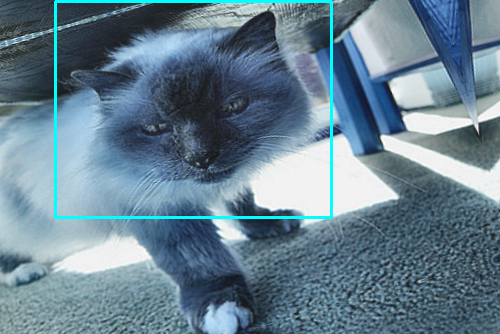

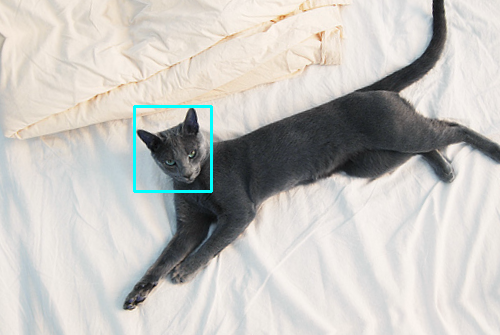

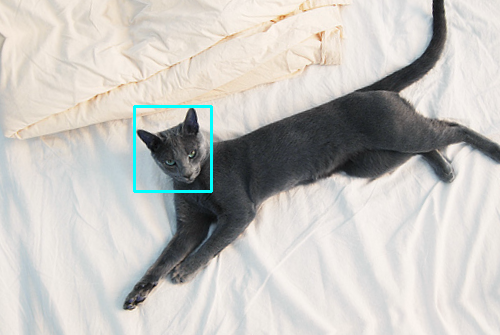

In [ ]:
# Toy Batched for Sanity Check
BATCH_SIZE = 20

train_ds = Dataset(df_train, train=True)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

val_ds = Dataset(df_test, train=False)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

batch = next(iter(train_dl))
val_batch = next(iter(val_dl))

disp_batch(batch)
disp_batch(batch)
disp_batch(batch)

In [12]:
class LitModel(pl.LightningModule):
    def __init__(self,
                 model:nn.Module,
                 optimizer:optim,
                 train_dl:torch.utils.data.DataLoader,
                 val_dl:torch.utils.data.DataLoader,
                 max_lr:float,
                 scheduler:optim.lr_scheduler=None, 
                 ):
        
        super(LitModel, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.scheduler = scheduler
        self.max_lr = max_lr

    def configure_optimizers(self, *args, **kwargs):
        optimizer = self.optimizer
        if self.scheduler is not None:
            scheduler = self.scheduler
            return [optimizer], [scheduler]
        else:
            return [optimizer]

    def optimizer_step(self, *args, **kwargs):
        # warmup lr
        if self.trainer.global_step < 500:
            alpha = min(1., float(self.trainer.global_step + 1) / 500.)
            for pg in self.optimizer.param_groups:
                pg['lr'] = alpha * self.max_lr

        # update params
        optimizer.step()
        optimizer.zero_grad()

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def train_dataloader(self, *args, **kwargs):
        return self.train_dl

    def val_dataloader(self, *args, **kwargs):
        valid_loader = self.val_dl

        # Prepare COCO Evaluator
        coco = get_coco_api_from_dataset(valid_loader.dataset)
        iou_types = ["bbox"]
        self.coco_evaluator = CocoEvaluator(coco, iou_types)
        return valid_loader

    def training_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        # Separate Losses
        loss_dict = self.model(images, targets)
        # Total Loss
        losses = sum(loss for loss in loss_dict.values())
        return {'loss': losses, 'log': loss_dict, 'progress_bar': loss_dict}

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        self.coco_evaluator.update(res)
        
        return {}

    def validation_epoch_end(self, outputs):
        self.coco_evaluator.accumulate()
        self.coco_evaluator.summarize()

        # coco main metric
        metric = self.coco_evaluator.coco_eval['bbox'].stats[0]
        metric = torch.as_tensor(metric)
        tensorboard_logs = {'bbox_IOU': metric}
        return {'val_loss': metric, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}

In [13]:
###################################### Training Configurations ############################################

# --------------------------------------------------------------------------------------------------
# Model
# --------------------------------------------------------------------------------------------------
model = Retinanet(num_classes=len(df['target'].unique()), backbone_kind='resnet18', pretrained=True)

# Freeze `Backbone`
for param in model.backbone.parameters():
    param.requires_grad = False

# --------------------------------------------------------------------------------------------------
# Inputs
# --------------------------------------------------------------------------------------------------
TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 12

# Train DataLoader
train_ds = Dataset(df_train, train=True)
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=TRAIN_BATCH_SIZE,
                                       shuffle=True,
                                       collate_fn=collate_fn,
                                       pin_memory=True)

# Valid DataLoader
val_ds = Dataset(df_test, train=False)
val_dl = torch.utils.data.DataLoader(val_ds, 
                                     batch_size=VALID_BATCH_SIZE,
                                     shuffle=False,
                                     collate_fn=collate_fn,
                                     pin_memory=True)


# --------------------------------------------------------------------------------------------------
# Training Options
# --------------------------------------------------------------------------------------------------
EPOCHS = 20
MAX_LR = 1e-03
WD = 1e-02

# Optimzier and LrScheduler
optimizer = optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=MAX_LR,
    momentum=0.9,
    weight_decay=WD)

lr_scheduler = {
    "scheduler": optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9),
    "step" : 'epoch' }


# --------------------------------------------------------------------------------------------------
# PyTorchLightning CallBacks
# --------------------------------------------------------------------------------------------------
tb_logger = pl.loggers.TensorBoardLogger(save_dir="/content/logs")
# TensorBoard Logger

# CheckPoint Logger
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    "content/saved_models", 
    mode= "max",
    monitor = "bbox_IOU",
    save_top_k = -1)

# EarlyStopping Callback
early_stopping_callback = pl.callbacks.EarlyStopping(
    mode= 'max',
    monitor= "bbox_IOU",
    patience = 5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [14]:
lightning_model = LitModel(model, 
                           optimizer,
                           train_dl, val_dl,
                           max_lr = MAX_LR,
                           scheduler=lr_scheduler
                           )

trainer = pl.Trainer(logger=[tb_logger],
                     gradient_clip_val = 0.5,
                     checkpoint_callback=checkpoint_callback,
                     max_epochs=EPOCHS, 
                     precision = 16,
                     gpus = 1,
                     num_sanity_val_steps = 0,
                     accumulate_grad_batches=5)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [15]:
trainer.fit(lightning_model)


  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 20 M  


creating index...
index created!


TypeError: ignored